# Open problems: solution to exercise 2

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import time
import numpy as np
import threading
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.data import Observation, observatory_locations, FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    GaussianSpatialModel,
    GaussianTemporalModel,
    ConstantTemporalModel,
    ExpDecayTemporalModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models
)

Let's simulate the source at 1 kpc with a powerlaw spectral shape with $\Gamma=2$ and amplitude of $10^{-12}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$. 

The integrated flux is: 
$F_{1~\text{kpc}} = \int_{0.01~\text{TeV}}^{10~\text{TeV}} N_{1~\text{kpc}} \cdot (\cfrac{E}{E_0})^{-\Gamma} dE$

from which we can estimate the luminosity, which is unvariant for the distance:

$L_{\gamma} = F_{1~\text{kpc}} \cdot 4 \cdot \pi \cdot D_{1~\text{kpc}}^2$

$L_{\gamma} = F \cdot 4 \cdot \pi \cdot D^2$


Therefore, the powerlaw amplitude $N_D$ scales with the distance as:

$N_D = N_{1~\text{kpc}} \cdot (\cfrac{1~\text{kpc}}{D})^2$

In [2]:
# let's determine the powerlaw amplitude for the different distances:

distances = [1, 2, 3, 4, 5, 7, 10, 15, 20] * u.kpc
amplitudes = 1e-12 * u.cm**-2 * u.s**-1 * u.TeV**-1 * (1 * u.kpc / distances)**2
amplitudes

<Quantity [1.00000000e-12, 2.50000000e-13, 1.11111111e-13, 6.25000000e-14,
           4.00000000e-14, 2.04081633e-14, 1.00000000e-14, 4.44444444e-15,
           2.50000000e-15] 1 / (TeV s cm2)>

In [3]:
# create the observation and the dataset

energy_axis = MapAxis.from_energy_bounds("0.012589254 TeV", "199.52623 TeV",
                                         nbin=10, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds("0.001 TeV", "250 TeV", 
                                         nbin=10, per_decade=True, 
                                         name="energy_true")
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

In [4]:
# let's fix the source coordinates and the pointing direction:

target = SkyCoord("335 deg", "33 deg", unit="deg", frame="icrs")

pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [5]:
# let's load the IRF:

path = "/Users/fabiopintore/LAVORO/CTA/1st_CTAO_SCHOOL/Notebooks/caldb/CTA-Performance-prod5-v0.1-South-20deg/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
irf = load_irf_dict_from_file(path)

In [6]:
# let's the define the geometry:

geom = WcsGeom.create(
            skydir=pointing,
            width=(2.5, 2.5), #deg
            binsz=0.02, #deg
            frame="icrs",
            axes=[energy_axis],
            )

empty = MapDataset.create(
            geom,
            energy_axis_true=energy_axis_true,
            migra_axis=migra_axis,
            name="my-dataset",
            )

In [7]:
# let's create the observation object:

time_ref = Time("2024-06-25T00:00:00", format="isot", scale="utc")

livetime = 10 * u.hr

print(f"Simulation for exposure: {livetime}")
observation = Observation.create(
                obs_id="0001",
                pointing=pointing,
                livetime=livetime,
                irfs=irf,
                reference_time=time_ref,
                )
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

Simulation for exposure: 10.0 h


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [8]:
# let's create the source spatial model 
spatial_model = model = GaussianSpatialModel(
                            lon_0="335 deg",
                            lat_0="33 deg",
                            sigma="0.3 deg",
                            frame="icrs",
                            )

bkg = FoVBackgroundModel(dataset_name="my-dataset")

In [9]:
# Let's loop over the different distances, i.e. different amplitudes.
# For each, we fit the simulated events and estimate the sigma and its uncertainty.

sigmas, errors = [], []
for N, dist in zip(amplitudes, distances):
    print(f"Calculation for a distance of {dist}")
    spectral_model = PowerLawSpectralModel(index=2, amplitude=N, reference="1 TeV")
    
    source_model = SkyModel(spectral_model = spectral_model,
                           spatial_model = spatial_model,
                           name = "fake_src")
    
    full_model = Models([source_model, bkg])
    
    dataset.models = full_model

    sampler = MapDatasetEventSampler(random_state=0)
    events = sampler.run(dataset, observation)

    counts = Map.from_geom(geom)
    counts.fill_events(events)
    dataset.counts = counts

    dataset.models.parameters["lon_0"].frozen = True
    dataset.models.parameters["lat_0"].frozen = True

    fit = Fit()
    result = fit.run(dataset)
    sigmas.append(result.models[0].spatial_model.sigma.value)
    errors.append(result.models[0].spatial_model.sigma.error)
    print(result)

Calculation for a distance of 1.0 kpc


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/random/inverse_cdf.py:32: RuntimeWarning: invalid value encountered in divide
  self.cdf /= self.cdf[:, [-1]]
The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 104
	total stat : -543720.48

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 2.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 99
	total stat : -545806.44

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 3.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 141
	total stat : -546519.74

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 4.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -545316.82

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 5.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 175
	total stat : -541809.55

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 7.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 175
	total stat : -542332.84

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 10.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 190
	total stat : -545060.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 15.0 kpc


The meta information will be empty here.


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 370
	total stat : -544144.81

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 20.0 kpc


The meta information will be empty here.
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 277
	total stat : -543991.77

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Let's plot our results as a function of the distance:

Text(0.5, 1.0, 'Constrain on the source extension')

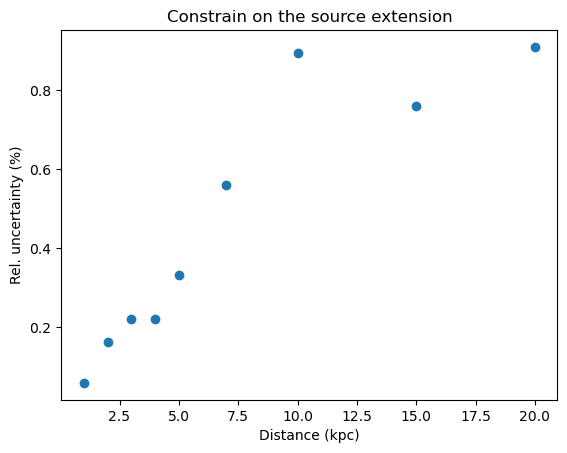

In [10]:
plt.plot(distances, np.array(errors) / np.array(sigmas), "o")
#plt.loglog()
plt.xlabel("Distance (kpc)")
plt.ylabel("Rel. uncertainty (%)")
plt.title("Constrain on the source extension")